In [164]:
import joblib
import pickle
import base64
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib

In [165]:
df=pd.read_csv('spam_dataset.csv',encoding='latin-1')
df.head()

,label,text
0,spam,naturally irresistible your corporate identity...
1,spam,the stock trading gunslinger fanny is merrill ...
2,spam,unbelievable new homes made easy im wanting to...
3,spam,4 color printing special request additional in...
4,spam,do not have money get software cds from here s...


In [166]:
df.shape

(20348, 2)

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20348 entries, 0 to 20347
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   20348 non-null  object
 1   text    20348 non-null  object
dtypes: object(2)
memory usage: 318.1+ KB


In [168]:
df['text']

0        naturally irresistible your corporate identity...
1        the stock trading gunslinger fanny is merrill ...
2        unbelievable new homes made easy im wanting to...
3        4 color printing special request additional in...
4        do not have money get software cds from here s...
                               ...                        
20343                                                 /ban
20344                                                 /ban
20345                                                 /ban
20346                                            Kaisi hii
20347                                              Shock q
Name: text, Length: 20348, dtype: object

In [169]:
df.drop_duplicates(inplace=True)

In [170]:
spam_count = len(df[df['label'] == 'spam'])
ham_count = len(df[df['label'] == 'ham'])
total_messages = len(df)
spam_percentage = (spam_count / total_messages) * 100
ham_percentage = (ham_count / total_messages) * 100
print(f"spam_count: {spam_count}")
print(f"ham_count: {ham_count}")
print(f"total_messages: {total_messages}")


spam_count: 6011
ham_count: 14323
total_messages: 20334


(-1.1840870762563476,
 1.104003570880801,
 -1.1029919364543506,
 1.1628821183506632)

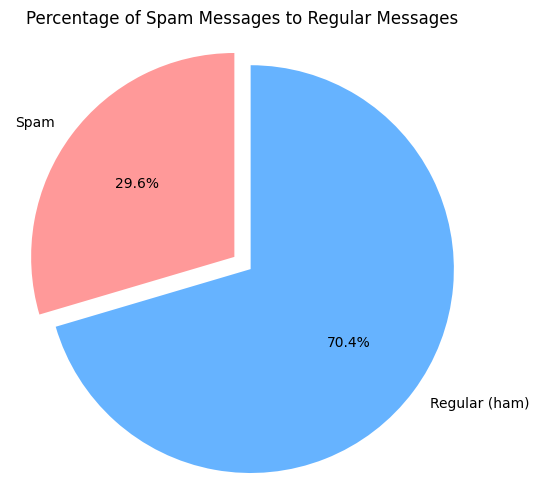

In [171]:
labels = ['Spam', 'Regular (ham)']
sizes = [spam_percentage, ham_percentage]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Spam Messages to Regular Messages')
plt.axis('equal')

<Axes: xlabel='label'>

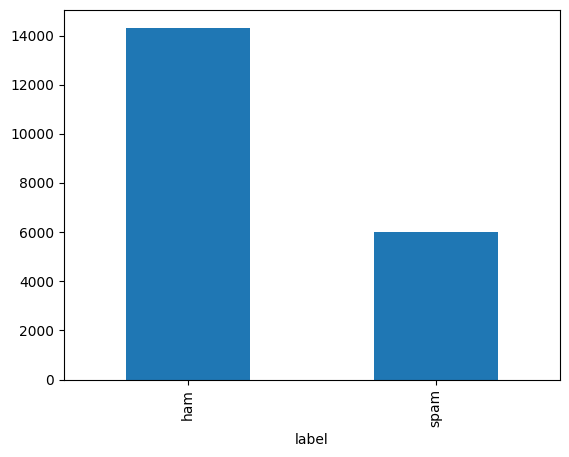

In [172]:
df['label'].value_counts().plot.bar()

Text(0.5, 1.0, 'Distribution of Number of Characters in Messages')

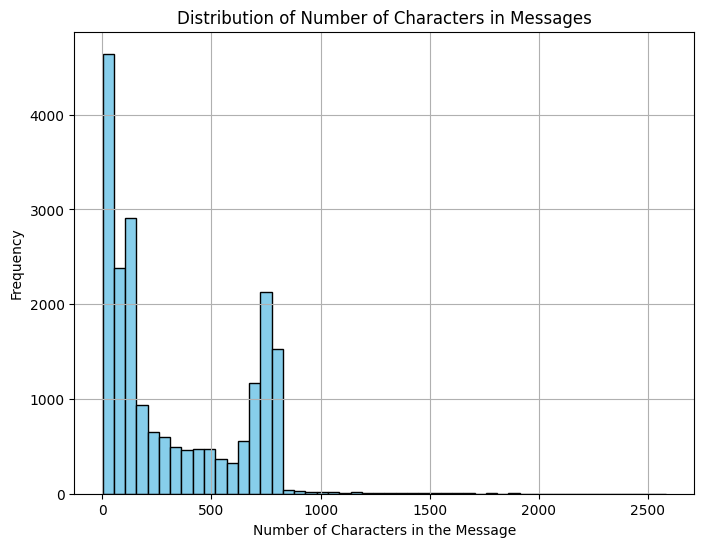

In [173]:
df['number_of_characters_in_the_message'] = df['text'].apply(len)
plt.figure(figsize=(8, 6))
df['number_of_characters_in_the_message'].hist(bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Number of Characters in the Message')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Characters in Messages')

# Data PreProcessing

In [174]:
def lowerChange(text):
    return text.lower() 

df['']=df['text'].apply(lowerChange)
df['text']

0        naturally irresistible your corporate identity...
1        the stock trading gunslinger fanny is merrill ...
2        unbelievable new homes made easy im wanting to...
3        4 color printing special request additional in...
4        do not have money get software cds from here s...
                               ...                        
20333    SPAM ALERT  ð  User:     Username: @DillyBu...
20341                                             Hum ky h
20342                                                 /ban
20346                                            Kaisi hii
20347                                              Shock q
Name: text, Length: 20334, dtype: object

In [175]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


def Preprocess(text):
    #Remove punctations & numbers
    text=re.sub(r"[^a-zA-Z]", " ", text)
    
    #tokenize sentence into words 
    words=word_tokenize(text)
    
    #Remove stopwords
    stop_words=set(stopwords.words("english"))
    words=[word for word in words if word not in stop_words]
    
    return words
    

df['txt']=df['text'].apply(Preprocess)
df.head(10)

,label,text,number_of_characters_in_the_message,,txt
0,spam,naturally irresistible your corporate identity...,769,naturally irresistible your corporate identity...,"[naturally, irresistible, corporate, identity,..."
1,spam,the stock trading gunslinger fanny is merrill ...,585,the stock trading gunslinger fanny is merrill ...,"[stock, trading, gunslinger, fanny, merrill, m..."
2,spam,unbelievable new homes made easy im wanting to...,416,unbelievable new homes made easy im wanting to...,"[unbelievable, new, homes, made, easy, im, wan..."
3,spam,4 color printing special request additional in...,436,4 color printing special request additional in...,"[color, printing, special, request, additional..."
4,spam,do not have money get software cds from here s...,199,do not have money get software cds from here s...,"[money, get, software, cds, software, compatib..."
5,spam,great nnews hello welcome to medzonline sh gro...,435,great nnews hello welcome to medzonline sh gro...,"[great, nnews, hello, welcome, medzonline, sh,..."
6,spam,here s a hot play in motion homeland security ...,762,here s a hot play in motion homeland security ...,"[hot, play, motion, homeland, security, invest..."
7,spam,save your money buy getting this thing here yo...,404,save your money buy getting this thing here yo...,"[save, money, buy, getting, thing, tried, cial..."
8,spam,undeliverable home based business for grownups...,423,undeliverable home based business for grownups...,"[undeliverable, home, based, business, grownup..."
9,spam,save your money buy getting this thing here yo...,404,save your money buy getting this thing here yo...,"[save, money, buy, getting, thing, tried, cial..."


In [176]:
df.drop('text',axis=1,inplace=True)


1=Spam
0=Ham

In [177]:
df = pd.read_csv('spam_dataset.csv', skiprows=1, names=['label', 'text'])
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

# Vectorize Text

In [178]:
df.head()

,label,text
0,1,naturally irresistible your corporate identity...
1,1,the stock trading gunslinger fanny is merrill ...
2,1,unbelievable new homes made easy im wanting to...
3,1,4 color printing special request additional in...
4,1,do not have money get software cds from here s...


# DATA SPLITTING

In [179]:
train_data, temp_data, train_labels, temp_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=100
)

test_data, cv_data, test_labels, cv_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=100
)

# RESAMPLING

In [180]:
vectorizer = CountVectorizer(max_features=400)
train_data_numeric = vectorizer.fit_transform(train_data).toarray()
test_data_numeric = vectorizer.transform(test_data).toarray()

ros = RandomOverSampler(random_state=42)
train_data_resampled, train_labels_resampled = ros.fit_resample(train_data_numeric, train_labels)
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data_resampled)
test_data_normalized = scaler.transform(test_data_numeric)

class_weights = {
    0: 1.0,
    1: 1.3
}

# MODELLING

In [181]:
tf.random.set_seed(1234)

model = Sequential([
    Dense(128, activation='relu', input_shape=(400,), name="L1"),
    Dropout(0.5),
    Dense(64, activation='relu', name="L2"),
    Dropout(0.3),
    Dense(32, activation='relu', name="L3"),
    Dropout(0.3),
    Dense(1, activation='sigmoid', name="Output"),
], name="my_model")

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

In [182]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [183]:
model_checkpoint = ModelCheckpoint(
    'spam_classifier_model.h5',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# TRAINING 

In [184]:
def data_generator(data, labels, batch_size):
    num_samples = len(data)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        yield data[indices], np.array(labels[indices])[:, np.newaxis]


In [185]:
# Clear session before starting
tf.keras.backend.clear_session()

# Training loop
batch_size = 65
steps_per_epoch = len(train_data_normalized) // batch_size

epochs = 60
history_list = []

for epoch in range(epochs):
    history = model.fit(
        data_generator(train_data_normalized, train_labels_resampled, batch_size),
        epochs=1,
        steps_per_epoch=steps_per_epoch,
        validation_data=(test_data_normalized, np.array(test_labels.values)[:, np.newaxis]),
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weights
    )

    history_list.append(history.history)

# Save training history
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history_list, file)

# Save model in the native Keras format
model.save('my_model.keras')

# Save model in TensorFlow SavedModel format
model.save('my_model_tf')

# Load the model from the TensorFlow SavedModel format
loaded_model = tf.keras.models.load_model('my_model_tf')

# Make predictions and evaluate
train_pred_prob = loaded_model.predict(train_data_normalized)
test_pred_prob = loaded_model.predict(test_data_normalized)

train_pred = (train_pred_prob > 0.5).astype(int)
test_pred = (test_pred_prob > 0.5).astype(int)

print('Train Accuracy - ', accuracy_score(train_labels_resampled, train_pred))
print("Test Accuracy - ", accuracy_score(test_labels, test_pred))

352/353 [============================>.] - ETA: 0s - loss: 0.7797 - accuracy: 0.5567
Epoch 1: val_loss improved from inf to 0.67799, saving model to spam_classifier_model.h5
 15/353 [>.............................] - ETA: 1s - loss: 0.7428 - accuracy: 0.6256

d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


348/353 [============================>.] - ETA: 0s - loss: 0.6565 - accuracy: 0.6788
Epoch 1: val_loss improved from 0.67799 to 0.47642, saving model to spam_classifier_model.h5
  1/353 [..............................] - ETA: 5s - loss: 0.5301 - accuracy: 0.8308

d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


348/353 [============================>.] - ETA: 0s - loss: 0.5111 - accuracy: 0.7763
Epoch 1: val_loss improved from 0.47642 to 0.39689, saving model to spam_classifier_model.h5
353/353 [==============================] - 1s 4ms/step - loss: 0.5107 - accuracy: 0.7763 - val_loss: 0.3969 - val_accuracy: 0.8206


d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


350/353 [============================>.] - ETA: 0s - loss: 0.4438 - accuracy: 0.8118
Epoch 1: val_loss improved from 0.39689 to 0.35850, saving model to spam_classifier_model.h5
  1/353 [..............................] - ETA: 5s - loss: 0.4795 - accuracy: 0.8000

d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


346/353 [============================>.] - ETA: 0s - loss: 0.4141 - accuracy: 0.8249
Epoch 1: val_loss improved from 0.35850 to 0.34288, saving model to spam_classifier_model.h5
  1/353 [..............................] - ETA: 7s - loss: 0.3209 - accuracy: 0.8615

d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


347/353 [============================>.] - ETA: 0s - loss: 0.3879 - accuracy: 0.8411
Epoch 1: val_loss improved from 0.34288 to 0.33723, saving model to spam_classifier_model.h5
353/353 [==============================] - 2s 5ms/step - loss: 0.3872 - accuracy: 0.8413 - val_loss: 0.3372 - val_accuracy: 0.8536


d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/353 [============================>.] - ETA: 0s - loss: 0.3780 - accuracy: 0.8456
Epoch 1: val_loss improved from 0.33723 to 0.31652, saving model to spam_classifier_model.h5
353/353 [==============================] - 2s 5ms/step - loss: 0.3785 - accuracy: 0.8456 - val_loss: 0.3165 - val_accuracy: 0.8698


d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/353 [============================>.] - ETA: 0s - loss: 0.3657 - accuracy: 0.8496
Epoch 1: val_loss improved from 0.31652 to 0.31641, saving model to spam_classifier_model.h5
353/353 [==============================] - 2s 5ms/step - loss: 0.3653 - accuracy: 0.8497 - val_loss: 0.3164 - val_accuracy: 0.8678


d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


348/353 [============================>.] - ETA: 0s - loss: 0.3493 - accuracy: 0.8576
Epoch 1: val_loss improved from 0.31641 to 0.30206, saving model to spam_classifier_model.h5
353/353 [==============================] - 2s 5ms/step - loss: 0.3497 - accuracy: 0.8574 - val_loss: 0.3021 - val_accuracy: 0.8752


d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


341/353 [===========================>..] - ETA: 0s - loss: 0.3473 - accuracy: 0.8562
Epoch 1: val_loss did not improve from 0.30206
346/353 [============================>.] - ETA: 0s - loss: 0.3387 - accuracy: 0.8603
Epoch 1: val_loss did not improve from 0.30206
351/353 [============================>.] - ETA: 0s - loss: 0.3287 - accuracy: 0.8653
Epoch 1: val_loss improved from 0.30206 to 0.29842, saving model to spam_classifier_model.h5
353/353 [==============================] - 2s 5ms/step - loss: 0.3290 - accuracy: 0.8652 - val_loss: 0.2984 - val_accuracy: 0.8747


d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


353/353 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.8665
Epoch 1: val_loss improved from 0.29842 to 0.29133, saving model to spam_classifier_model.h5
353/353 [==============================] - 2s 5ms/step - loss: 0.3295 - accuracy: 0.8665 - val_loss: 0.2913 - val_accuracy: 0.8742


d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


346/353 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.8742
Epoch 1: val_loss did not improve from 0.29133
353/353 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.8771
Epoch 1: val_loss improved from 0.29133 to 0.28310, saving model to spam_classifier_model.h5
353/353 [==============================] - 2s 4ms/step - loss: 0.3083 - accuracy: 0.8771 - val_loss: 0.2831 - val_accuracy: 0.8801


d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


339/353 [===========================>..] - ETA: 0s - loss: 0.3036 - accuracy: 0.8771
Epoch 1: val_loss improved from 0.28310 to 0.27636, saving model to spam_classifier_model.h5
  1/353 [..............................] - ETA: 6s - loss: 0.3156 - accuracy: 0.8769

d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


344/353 [============================>.] - ETA: 0s - loss: 0.2912 - accuracy: 0.8807
Epoch 1: val_loss did not improve from 0.27636
350/353 [============================>.] - ETA: 0s - loss: 0.2897 - accuracy: 0.8825
Epoch 1: val_loss did not improve from 0.27636
347/353 [============================>.] - ETA: 0s - loss: 0.2822 - accuracy: 0.8847
Epoch 1: val_loss did not improve from 0.27636
350/353 [============================>.] - ETA: 0s - loss: 0.2758 - accuracy: 0.8897
Epoch 1: val_loss improved from 0.27636 to 0.26565, saving model to spam_classifier_model.h5
  1/353 [..............................] - ETA: 6s - loss: 0.2298 - accuracy: 0.9385

d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


353/353 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.8868
Epoch 1: val_loss improved from 0.26565 to 0.25842, saving model to spam_classifier_model.h5
  1/353 [..............................] - ETA: 6s - loss: 0.2012 - accuracy: 0.9692

d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


338/353 [===========================>..] - ETA: 0s - loss: 0.2620 - accuracy: 0.8956
Epoch 1: val_loss did not improve from 0.25842
342/353 [============================>.] - ETA: 0s - loss: 0.2647 - accuracy: 0.8936
Epoch 1: val_loss improved from 0.25842 to 0.25554, saving model to spam_classifier_model.h5
  1/353 [..............................] - ETA: 5s - loss: 0.2213 - accuracy: 0.9077

d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


346/353 [============================>.] - ETA: 0s - loss: 0.2556 - accuracy: 0.8993
Epoch 1: val_loss improved from 0.25554 to 0.25198, saving model to spam_classifier_model.h5
353/353 [==============================] - 2s 4ms/step - loss: 0.2560 - accuracy: 0.8989 - val_loss: 0.2520 - val_accuracy: 0.8943


d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/353 [============================>.] - ETA: 0s - loss: 0.2477 - accuracy: 0.9030
Epoch 1: val_loss did not improve from 0.25198
342/353 [============================>.] - ETA: 0s - loss: 0.2393 - accuracy: 0.9059
Epoch 1: val_loss did not improve from 0.25198
343/353 [============================>.] - ETA: 0s - loss: 0.2313 - accuracy: 0.9099
Epoch 1: val_loss did not improve from 0.25198
340/353 [===========================>..] - ETA: 0s - loss: 0.2349 - accuracy: 0.9058
Epoch 1: val_loss did not improve from 0.25198
338/353 [===========================>..] - ETA: 0s - loss: 0.2369 - accuracy: 0.9071
Epoch 1: val_loss did not improve from 0.25198
344/353 [============================>.] - ETA: 0s - loss: 0.2257 - accuracy: 0.9097
Epoch 1: val_loss improved from 0.25198 to 0.25073, saving model to spam_classifier_model.h5
353/353 [==============================] - 2s 5ms/step - loss: 0.2254 - accuracy: 0.9099 - val_loss: 0.2507 - val_accuracy: 0.8811


d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


338/353 [===========================>..] - ETA: 0s - loss: 0.2175 - accuracy: 0.9140
Epoch 1: val_loss improved from 0.25073 to 0.24143, saving model to spam_classifier_model.h5
353/353 [==============================] - 1s 4ms/step - loss: 0.2192 - accuracy: 0.9133 - val_loss: 0.2414 - val_accuracy: 0.9002


d:\OneDrive\Desktop\neural_network_with_flask\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/353 [============================>.] - ETA: 0s - loss: 0.2166 - accuracy: 0.9111
Epoch 1: val_loss did not improve from 0.24143
352/353 [============================>.] - ETA: 0s - loss: 0.2146 - accuracy: 0.9154
Epoch 1: val_loss did not improve from 0.24143
353/353 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9136
Epoch 1: val_loss did not improve from 0.24143
344/353 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.9183
Epoch 1: val_loss did not improve from 0.24143
345/353 [============================>.] - ETA: 0s - loss: 0.2004 - accuracy: 0.9167
Epoch 1: val_loss did not improve from 0.24143
342/353 [============================>.] - ETA: 0s - loss: 0.2005 - accuracy: 0.9182
Epoch 1: val_loss did not improve from 0.24143
350/353 [============================>.] - ETA: 0s - loss: 0.1950 - accuracy: 0.9190
Epoch 1: val_loss did not improve from 0.24143
340/353 [===========================>..] - ETA: 0s - loss: 0.1909 - accuracy

INFO:tensorflow:Assets written to: my_model_tf\assets


64/64 [==============================] - 0s 1ms/step
Train Accuracy -  0.9505614065627992
Test Accuracy -  0.8928746928746929


# RESULT

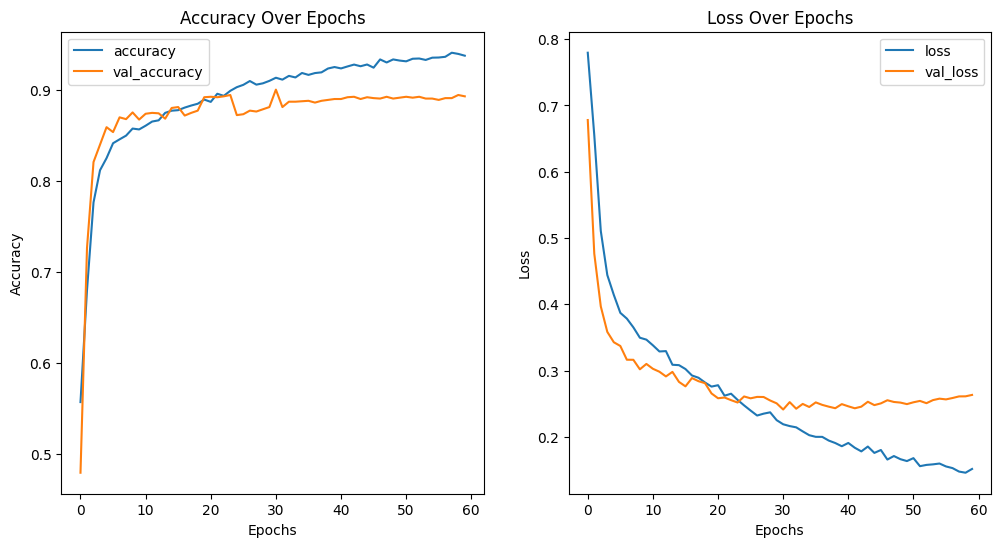

In [188]:
with open('training_history.pkl', 'rb') as file:
        history_list = pickle.load(file)
        
accuracy = [acc for epoch_history in history_list for acc in epoch_history['accuracy']]
val_accuracy = [val_acc for epoch_history in history_list for val_acc in epoch_history['val_accuracy']]
loss = [l for epoch_history in history_list for l in epoch_history['loss']]
val_loss = [val_l for epoch_history in history_list for val_l in epoch_history['val_loss']]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

162/162 [==============================] - 0s 1ms/step
Accuracy: 0.8013
Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.78      0.87      4510
        spam       0.38      0.95      0.55       653

    accuracy                           0.80      5163
   macro avg       0.69      0.87      0.71      5163
weighted avg       0.91      0.80      0.83      5163



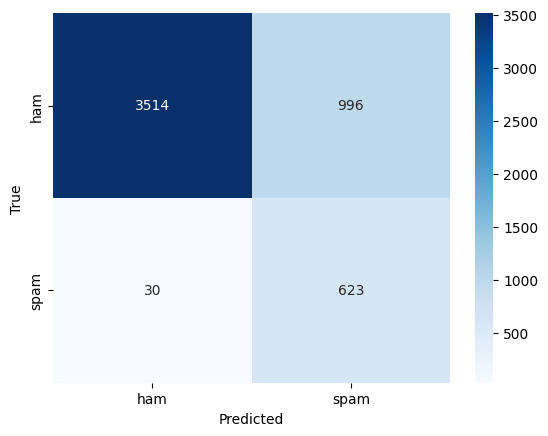

In [189]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from joblib import dump


# Load the trained model and vectorizer
try:
    dump(model, 'my_model.keras')
    with open('vectorizer.joblib', 'wb') as file:
        dump(vectorizer, file)
except Exception as e:
    print(f"Error loading model or vectorizer: {e}")
    # Add further error handling if needed

# Load the test dataset
try:
    test_data = pd.read_csv('test_dataset.csv', encoding='latin-1')
    test_data.drop_duplicates(inplace=True)
    test_data['v1'] = test_data['v1'].map({'spam': 1, 'ham': 0})
    test_data = test_data.dropna(subset=['v2'])
    test_data.drop_duplicates(inplace=True)
except Exception as e:
    print(f"Error loading test dataset: {e}")
    # Add further error handling if needed

# Make predictions
try:
    test_predictions = model.predict(vectorizer.transform(test_data['v2']))
except Exception as e:
    print(f"Error making predictions: {e}")
    # Add further error handling if needed

# Evaluate the model
accuracy = accuracy_score(test_data['v1'], (test_predictions > 0.5).astype(int))
print(f'Accuracy: {accuracy:.4f}')

# Classification Report
labels = ['ham', 'spam']
classification_rep = classification_report(test_data['v1'], (test_predictions > 0.5).astype(int), target_names=labels)
print('Classification Report:\n', classification_rep)

# Confusion Matrix
cm = confusion_matrix(test_data['v1'], (test_predictions > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
